### ANN for regression, example 2, house market data (how to handle categorical variables)

##### Version 2: using some common optimization approaches

#### Imports / modules

In [293]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

#### Loading the dataset

In [294]:
# load the data
df = pd.read_csv("Housing.csv")

In [295]:
# deep learning / neural network-wise, this is quite a small dataset
len(df)

545

In [296]:
# let's see the first 5 rows 
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [297]:
df['furnishingstatus'].value_counts()

# usually we are only interested if the house
# is furnished AT ALL or completely unfurnished
# what if we combine semi-furnished with furnished?
# (there's no way knowing if this works, it's more about trying creative
# approaches in order to simplify/optimize the dataset)

furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64

### Handling the categorical variables

In [298]:
# WE HAVE SOME BOOLEAN CATEGORIES
# => change them to 0 and 1

# this just converts the value of column to 0 or 1
# factorize in pandas works too, but only one column at a time
from sklearn.preprocessing import LabelEncoder
variables = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

In [299]:
# let's see how our dataset now changed
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### Convert text categories with multiple choices into multiple variables

In [300]:
# SINCE WE ARE GOING TO MODIFY THE furnishingstatus from three options
# to two options, we no longer need OneHotEncoder, since this is now 
# goint to be a boolean/binary variable

# # this makes multiple columns with the variable (Separate for yes/no)
# from sklearn.preprocessing import OneHotEncoder
# variables = ['furnishingstatus']

# # use encoder
# encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
# df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [301]:
# create a helper function for pandas and replace
# the different furnishingstatus values into either 0 or 1
def modify_furnishing(row):
    if row['furnishingstatus'] == 'unfurnished':
        return 0
    else:
        return 1
    
# create a new boolean/binary furnished status 
# 0 => not furnished
# 1 => either fully or partially furnished
df['furnished'] = df.apply(modify_furnishing, axis=1)

# drop the original 3-option furnishing status
df = df.drop("furnishingstatus", axis=1)

In [302]:
# no longer needed, since we don't use OneHotEncoder anymore for this
# # we can alwasy remove EXACTLY ONE option per variable when we use OneHotEncoder
# df = df.drop("furnishingstatus_unfurnished", axis=1)

In [303]:
# let's see what happened to our dataset
df.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,1
6,10150000,8580,4,3,4,1,0,0,0,1,2,1,1
7,10150000,16200,5,3,2,1,0,0,0,0,0,0,0
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,0


#### Removing outliers

In [304]:
# usually the most straight-forward / quick&dirty -solution is to use
# scipy and z-score

# version 1, SciPy, extreme outliers that go under -3 or over +3 in normal distribution
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

# see also the quantile -based removal in Moodle, you have more control
# over what is removed

#### You can also get as fancy you wish with outlier detection and removal

In [305]:
# let's try a fancier example for outlier removal
# this code is originally from:
# https://stackoverflow.com/questions/69248118/detect-outliers-across-all-columns-of-pandas-dataframe

def find_outliers(col):
    q1 = col.quantile(.15)
    q3 = col.quantile(.85)
    IQR = q3 - q1
    ll = q1 - (1.5*IQR)
    ul = q3 + (1.5*IQR)
    upper_outliers = col[col > ul].index.tolist()
    lower_outliers = col[col < ll].index.tolist()
    bad_indices = list(set(upper_outliers + lower_outliers))
    return(bad_indices)

# get indexes of all outliers into a list
bad_indexes = []
for col in df.columns:
    if df[col].dtype in ["int64","float64"]:
        bad_indexes.append(find_outliers(df[col]))


# modify the list so that we can drop these rows from the DataFrame

bad_indexes = set(list(np.concatenate(bad_indexes).flat))

print(len(bad_indexes))

# drop the outliers
df = df.drop(bad_indexes)

110


<Axes: >

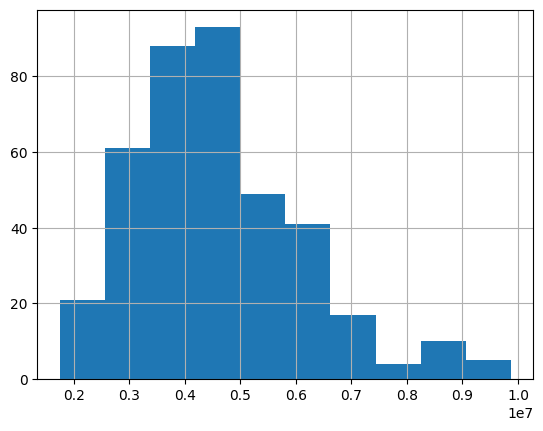

In [306]:
# it seems many of the more expensive houses were dropped off
# we still have slightly skewed distribution due to expensive houses
df['price'].hist()

### X/y -split

In [307]:
# perform X/y -split
# if you  have more than one independent variable, list them all here
# leave out the target variable! (dependent variable)

# this is a nice and common trick => everything EXCEPT target variable => support variable
X = df.drop("price", axis=1)

# have only the target variable here (dependent variable)
y = df["price"]

#### Use the different tools to figure out which variables are important and which are not

In [308]:
# the most basic tool of them all => correlations
correlations = df.corr(numeric_only=True)
correlations

# based on this, pretty much everything correlates with price
# so we don't have unusable variables
# for some reason, mainroad and hotwaterheating show as NaN (not a number)
# probably not enough data or variance to show a correlation

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished
price,1.00,0.49,0.37,0.43,0.20,NaN,0.33,0.27,NaN,0.46,0.26,0.37,0.31
area,0.49,1.00,0.11,0.13,-0.10,NaN,0.19,0.09,NaN,0.21,0.29,0.23,0.16
bedrooms,0.37,0.11,1.00,0.32,0.45,NaN,0.12,0.16,NaN,0.19,0.09,0.16,0.15
bathrooms,0.43,0.13,0.32,1.00,0.16,NaN,0.13,0.15,NaN,0.18,0.10,0.09,0.15
stories,0.20,-0.10,0.45,0.16,1.00,NaN,-0.00,-0.12,NaN,0.14,-0.13,0.05,0.06
mainroad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guestroom,0.33,0.19,0.12,0.13,-0.00,NaN,1.00,0.43,NaN,0.13,0.05,0.20,0.13
basement,0.27,0.09,0.16,0.15,-0.12,NaN,0.43,1.00,NaN,0.09,0.06,0.25,0.11
hotwaterheating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airconditioning,0.46,0.21,0.19,0.18,0.14,NaN,0.13,0.09,NaN,1.00,0.13,0.09,0.10


<Axes: >

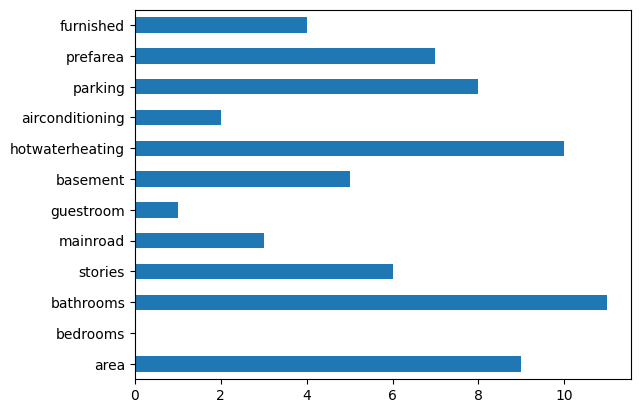

In [309]:
# pip install skfeature-chappers
from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation

# Fisher's score studies the variance of the data -> statistical significance'

# based on Fisher's score:
# num_rooms is not important at all, and num_people has minor importance in this data
# but ave_monthly_income is quite powerful based on Fisher's score

In [310]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on target variable
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
0,area,165447.39
9,parking,199.95
5,guestroom,176.03
10,prefarea,152.81
8,airconditioning,150.11
6,basement,125.20
11,furnished,70.32
3,stories,42.50
1,bedrooms,32.15
2,bathrooms,30.15


In [311]:
# pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
# VIF = Variance Inflation Factor
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  

# variables with high VIF-value 
# can mean multlicollinearity (variables providing same linear
# relationships in the data, potentially confusing the ML algorithm
# this might be good info when deciding if some variable needs to be removed
print(vif_data)

            feature   VIF
0              area  1.24
1          bedrooms  1.47
2         bathrooms  1.17
3           stories  1.41
4          mainroad 28.77
5         guestroom  1.29
6          basement  1.36
7   hotwaterheating   NaN
8   airconditioning  1.12
9           parking  1.14
10         prefarea  1.14
11        furnished  1.07


c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


### Train/test/validation -split

In [312]:
# in Classic ML, we only had train/test -split
# in deep learning, we usually use validation-data also, for better
# optimization possibilities and better metrics

# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.

# if you want to split the test set into two for a validation set too, try this trick:

# step 1, split the data into 70% (training data) and 30% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

#### Create a neural network structure

In [313]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression2_housing.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]

# Define Sequential neural network model
# input shape has to match the amount of SUPPORT VARIABLES
# in other words => amount of columns in X 

# Tip: have at least the same number of nodes as in the input shape

# since we have 13 support variables this time => 16 nodes in first layer

# output layer in regression is always 1 node without activation function
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.1)),
        layers.Dropout(0.2),
        layers.Dense(24, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
# model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer=keras.optimizers.RMSprop(0.00085), loss=keras.losses.Huber())
# model.compile(optimizer=keras.optimizers.SGD(0.001), loss="mse")
# an example where we alter the learning rate of Adam-optimizer
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00125), loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,673 (6.54 KB)

 Trainable params: 1,649 (6.44 KB)

 Non-trainable params: 24 (96.00 B)

### Train the neural network

In [314]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=800, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 23560544321536.0000 - val_loss: 20417590853632.0000
Epoch 2/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23560538030080.0000 - val_loss: 20417580367872.0000
Epoch 3/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23560533835776.0000 - val_loss: 20417565687808.0000
Epoch 4/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 23560527544320.0000 - val_loss: 20417551007744.0000
Epoch 5/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23560512864256.0000 - val_loss: 20417530036224.0000
Epoch 6/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23560496087040.0000 - val_loss: 20417496481792.0000
Epoch 7/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23560468824064.0000 - val_loss: 20417448247296.0000
Epoch 8/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 23560428978176.0000 - val_loss: 20417383235584.0000
Epoch 9/800
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 23560370257920.0000 - val_loss: 20417288863744.0000
Epoch 10/800
9/9 

### Performance and error metrics

<Axes: >

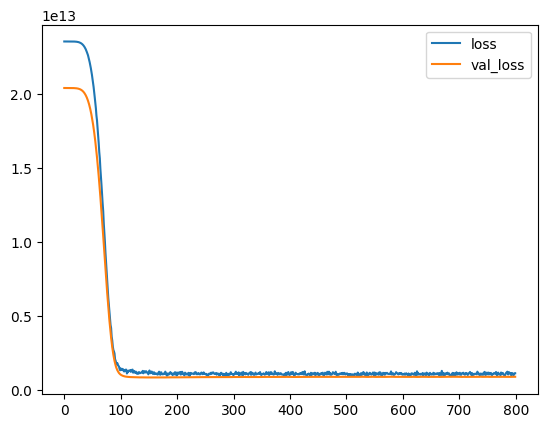

In [315]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Reload the best version of the model from history

In [316]:
from keras.models import load_model
model = load_model("best_model_regression2_housing.keras")

In [317]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
1093779914752.0

Train data evaluation:
959677726720.0


In [318]:
# get test predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


,Test True Y,Model Predictions
0,5880000,4952615.00
1,8645000,5766962.00
2,4585000,3844479.25
3,4095000,4328981.00
4,7000000,6432570.00
5,3605000,3614698.50
6,3234000,3618120.00
7,4165000,4012890.50
8,5229000,5839471.00
9,4403000,4028929.50


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

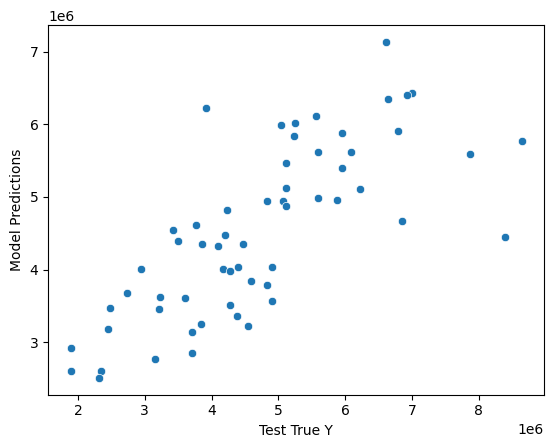

In [319]:
# these values follow a linear diagonal line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [320]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
767626.31 $

MSE
1093779849216.0 $^2

RMSE:
1045839.3 $

R-squared:
0.54

Explained variance score:
0.55


C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_2648\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


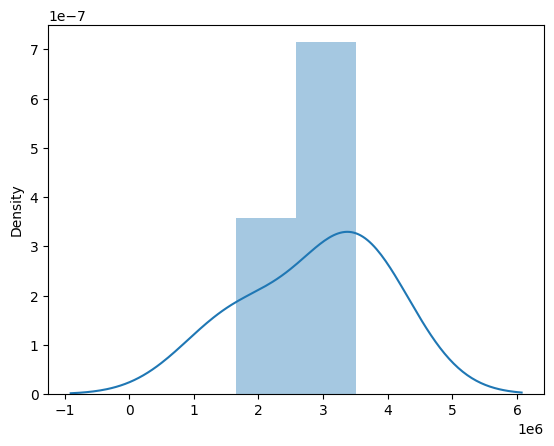

In [321]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

#### Trying the model in practice with new imaginary house

In [322]:
# just to see what kind of values are usually in the dataset
# so we can test with the tester_row
df.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished
8,9870000,8100,4,1,2,1,1,1,0,1,2,1,1
12,9310000,6550,4,2,2,1,0,0,0,1,1,1,1
14,9240000,7800,3,2,2,1,0,0,0,0,0,1,1


### TODO: fix the code below

In [323]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
    'area': 7420, 
    'bedrooms': 4, 
    'bathrooms': 2, 
    'stories': 3, 
    'mainroad': 1,
    'guestroom': 0, 
    'basement': 0, 
    'hotwaterheating': 0, 
    'airconditioning': 1,
    'parking': 2,
    'prefarea': 1,
    'furnishingstatus_furnished': 1,
    'furnishingstatus_semi-furnished:': 0
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [324]:
# get the prediction from the model and print out the result
result = model.predict(tester_row)[0]

print()
print(f"Estimated house price with this example:")
print(f"$ {round(float(result[0]), 2)}")
print("----------------")

InvalidArgumentError: Graph execution error:

Detected at node sequential_7_1/batch_normalization_3_1/batchnorm/mul_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "C:\Users\tuomas.valtanen\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 645, in run_forever

  File "C:\Users\tuomas.valtanen\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1999, in _run_once

  File "C:\Users\tuomas.valtanen\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 577, in run_cell

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3116, in run_cell

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3171, in _run_cell

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3394, in run_cell_async

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3639, in run_ast_nodes

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3699, in run_code

  File "C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_2648\4002590234.py", line 2, in <module>

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 566, in predict

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 260, in one_step_on_data_distributed

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 250, in one_step_on_data

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 105, in predict_step

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\layer.py", line 941, in __call__

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\ops\operation.py", line 59, in __call__

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\models\sequential.py", line 220, in call

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\ops\function.py", line 206, in _run_through_graph

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\models\functional.py", line 644, in call

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\layer.py", line 941, in __call__

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\ops\operation.py", line 59, in __call__

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py", line 277, in call

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\ops\nn.py", line 2267, in batch_normalization

  File "c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 879, in batch_normalization

Incompatible shapes: [1,13] vs. [12]
	 [[{{node sequential_7_1/batch_normalization_3_1/batchnorm/mul_1}}]] [Op:__inference_one_step_on_data_distributed_488854]

In [ ]:
# the model above undershoots the estimation
# should be 13.3 million => prediction is 6.45 million